In [58]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.stats import gaussian_kde

class PolymerMotion:
    def __init__(self, num_particles, spring_constants, mass=1.0, dt=0.01, total_time=10):
        self.num_particles = num_particles
        self.spring_constants = spring_constants
        self.mass = mass
        self.dt = dt
        self.total_time = total_time

        # Initialize positions and velocities
        self.positions = np.random.rand(num_particles, 2)  # Random initial positions in 2D
        self.velocities = np.zeros((num_particles, 2))  # Start with zero velocity
        self.time_steps = int(total_time / dt)  # Total number of time steps
        self.trajectory = np.zeros((self.time_steps, num_particles, 2))  # Store trajectory

    def forces(self):
        # Calculate the spring forces
        F = np.zeros((self.num_particles, 2))
        for i in range(self.num_particles):
            for j in range(i + 1, self.num_particles):
                # Calculate the spring force based on Hooke's law
                displacement = self.positions[j] - self.positions[i]
                distance = np.linalg.norm(displacement)
                if distance > 0:
                    spring_force = self.spring_constants[i] * displacement / distance
                    F[i] += spring_force
                    F[j] -= spring_force  # Action-Reaction pair
        return F

    def motion_equations(self, y, t):
        # Unpack positions and velocities
        positions = y[:self.num_particles * 2].reshape((self.num_particles, 2))
        velocities = y[self.num_particles * 2:].reshape((self.num_particles, 2))
        
        # Calculate forces
        F = self.forces()
        
        # Equations of motion
        dydt = np.zeros_like(y)
        dydt[:self.num_particles * 2] = velocities.flatten()  # d(position)/dt = velocity
        dydt[self.num_particles * 2:] = (F / self.mass).flatten()  # d(velocity)/dt = force/mass
        
        return dydt

    def simulate(self):
        # Initial state vector: [positions, velocities]
        initial_conditions = np.hstack((self.positions.flatten(), self.velocities.flatten()))
        t = np.linspace(0, self.total_time, self.time_steps)
        
        # Integrate the equations of motion
        solution = odeint(self.motion_equations, initial_conditions, t)
        
        # Extract positions from the solution
        positions = solution[:, :self.num_particles * 2].reshape((-1, self.num_particles, 2))
        self.trajectory = positions  # Store the trajectory
        return t, positions

    def generate_transition_matrix(self):
        # Create a transition matrix based on the entire trajectory
        transition_matrix = np.zeros((self.num_particles, self.num_particles))
        
        # Calculate cumulative displacement over the trajectory
        cumulative_displacements = np.zeros((self.num_particles, self.num_particles))
        for t in range(1, self.time_steps):
            for i in range(self.num_particles):
                for j in range(self.num_particles):
                    if i != j:
                        displacement = np.linalg.norm(self.trajectory[t, i] - self.trajectory[t, j])
                        cumulative_displacements[i, j] += displacement

        # Use cumulative displacement to adjust transition probabilities (closer -> higher probability)
        for i in range(self.num_particles):
            row_sum = cumulative_displacements[i].sum()
            if row_sum == 0:
                transition_matrix[i] = np.ones(self.num_particles) / self.num_particles
            else:
                for j in range(self.num_particles):
                    if i != j and cumulative_displacements[i, j] > 0:
                        transition_matrix[i, j] = 1 / cumulative_displacements[i, j]

        # Normalize rows to sum to 1
        row_sums = transition_matrix.sum(axis=1)
        for i in range(self.num_particles):
            if row_sums[i] > 0:
                transition_matrix[i] /= row_sums[i]
            else:
                transition_matrix[i] = np.ones(self.num_particles) / self.num_particles

        return transition_matrix

    def sample_random_walk(self, transition_matrix, num_steps, initial_state=0):
        state = initial_state
        visited_states = [state]

        for _ in range(num_steps):
            state = np.random.choice(self.num_particles, p=transition_matrix[state])
            visited_states.append(state)

        return visited_states

    def plot_probability_distribution(self, visited_states):
        # Create a histogram of visited states
        plt.figure(figsize=(10, 6))
        plt.hist(visited_states, bins=np.arange(self.num_particles + 1) - 0.5, density=True, alpha=0.6, color='b', edgecolor='black')
        plt.title('Probability Distribution from Random Walk')
        plt.xlabel('Node')
        plt.ylabel('Probability')
        plt.xticks(np.arange(self.num_particles))
        plt.grid()
        plt.xlim(-0.5, self.num_particles - 0.5)  # Set limits to match the bins
        plt.show()
        
        
    def plot_continuous_distribution(self, positions):
        # Use KDE to estimate the probability density function of the final positions
        final_positions = positions[-1]  # Get the final positions
        x = final_positions[:, 0]  # x-coordinates
        y = final_positions[:, 1]  # y-coordinates

        # Create a grid for the KDE
        kde_x = np.linspace(min(x), max(x), 100)
        kde_y = np.linspace(min(y), max(y), 100)
        kde_xx, kde_yy = np.meshgrid(kde_x, kde_y)

        # Estimate the density
        kde = gaussian_kde(final_positions.T)
        density = kde(np.vstack([kde_xx.ravel(), kde_yy.ravel()]))
        density = density.reshape(kde_xx.shape)

        # Plot the KDE
        plt.figure(figsize=(10, 6))
        plt.contourf(kde_xx, kde_yy, density, levels=30, cmap='Blues', alpha=0.7)
        plt.colorbar(label='Density')
        plt.scatter(final_positions[:, 0], final_positions[:, 1], c='red', s=10, label='Nodes', edgecolor='black')
        plt.title('Continuous Probability Distribution of Final Positions')
        plt.xlabel('X Position')
        plt.ylabel('Y Position')
        plt.legend()
        plt.show()

In [68]:
# Parameters
num_nodes = 10
spring_constants = np.random.rand(num_nodes)  # Random spring constants
mass = 1.0
dt = 0.01
total_time = 10  # Total simulation time
num_steps = 1000  # Number of steps for the random walk

# Initialize the PolymerMotion
polymer_motion = PolymerMotion(num_nodes, spring_constants, mass, dt, total_time)

# Simulate the polymer motion
time, positions = polymer_motion.simulate()

# Generate the transition matrix using the last positions
transition_matrix = polymer_motion.generate_transition_matrix()
print("Transition Matrix:\n", transition_matrix)

Transition Matrix:
 [[0.         0.10130775 0.07503009 0.14306962 0.11347199 0.07662423
  0.09936768 0.07090781 0.21938421 0.10083662]
 [0.05219823 0.         0.09293413 0.16104215 0.09031195 0.04887399
  0.11257166 0.0692042  0.08438927 0.28847441]
 [0.04269816 0.10264451 0.         0.08535435 0.1103543  0.081225
  0.16726671 0.26688264 0.0647571  0.07881723]
 [0.07396941 0.1615962  0.07754553 0.         0.13214242 0.05579336
  0.13081436 0.06503849 0.17721012 0.1258901 ]
 [0.05639933 0.0871199  0.09638311 0.12703483 0.         0.09276552
  0.26592907 0.09247275 0.11370895 0.06818655]
 [0.06651752 0.0823445  0.12390419 0.09368017 0.16202096 0.
  0.14552151 0.16103312 0.09428937 0.07068864]
 [0.04620084 0.10158291 0.13665975 0.1176401  0.24876268 0.07794028
  0.         0.11321477 0.08444245 0.07355623]
 [0.04354209 0.08247732 0.28797974 0.07724688 0.11424671 0.11390965
  0.14952493 0.         0.06421564 0.06685705]
 [0.13623305 0.10170709 0.07066281 0.21284375 0.14206479 0.06744813
  

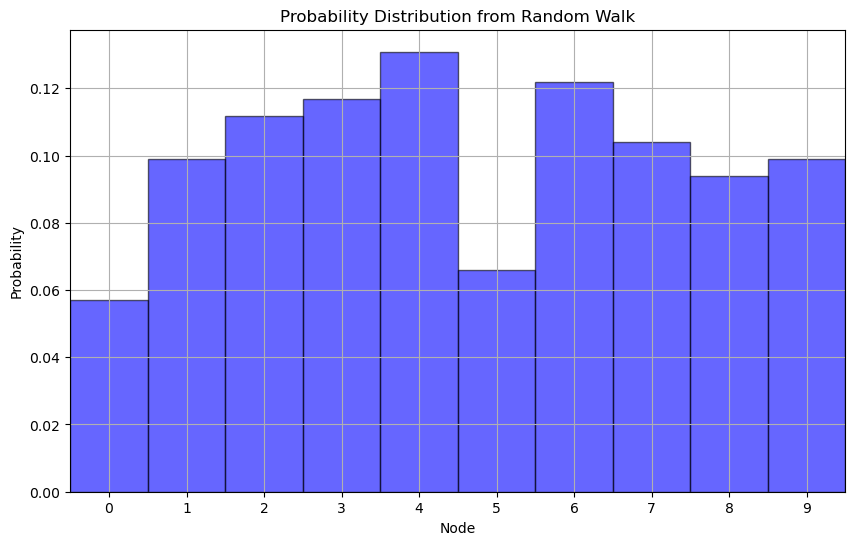

In [69]:
# Simulate a random walk
visited_states = polymer_motion.sample_random_walk(transition_matrix, num_steps)

# Plot the probability distribution of visited states
polymer_motion.plot_probability_distribution(visited_states)